# **Developing a machine learning model to predict the salary of baseball players**

## **Dataset Story**
* This dataset was originally taken from the StatLib library at Carnegie Mellon University.
* The dataset is part of the data used in the 1988 ASA Graphics Section Poster Session.
* Salary data originally from Sports Illustrated, April 20, 1987.
* 1986 and career statistics are from the 1987 Baseball Encyclopedia Update, published by Collier Books, Macmillan Publishing Company, New York.

## **Import Libraries**

In [577]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' %x)
pd.set_option('display.width', 500)

## **Import Dataset**

In [482]:
def dataset():
    dataframe = pd.read_csv('C:/Users/test/Desktop/PROGRAMMING/MIUUL_SUMMER_CAMP/03. machine_learning/odev_1/hitters.csv')
    return dataframe

df = dataset()
df.columns = [col.lower() for col in df.columns]
df.head()

,atbat,hits,hmrun,runs,rbi,walks,years,catbat,chits,chmrun,cruns,crbi,cwalks,league,division,putouts,assists,errors,salary,newleague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.000,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.000,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.000,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.500,N


In [483]:
df.isnull().sum()

atbat         0
hits          0
hmrun         0
runs          0
rbi           0
walks         0
years         0
catbat        0
chits         0
chmrun        0
cruns         0
crbi          0
cwalks        0
league        0
division      0
putouts       0
assists       0
errors        0
salary       59
newleague     0
dtype: int64

## **Exploratory Data Analysis**

### **General Picture of Dataset**

In [484]:
def check_df(dataframe, head = 5, tail = 5):
    print('*********************Head***********************')
    print(dataframe.head(head))
    print('\n*********************Tail***********************')
    print(dataframe.tail(tail))
    print('\n*********************Shape***********************')
    print(dataframe.shape)
    print('\n*********************Columns***********************')
    print(dataframe.columns)
    print('\n*********************Info***********************')
    print(dataframe.info())
    print('\n*********************Number Unique***********************')
    print(dataframe.nunique())
    print('\n*********************Index***********************')
    print(dataframe.index)
    print('\n*********************Missing Values in Variables***********************')
    print(dataframe.isnull().sum())
    print('\n*********************Missing Values or Not***********************')
    print(dataframe.isnull().values.any())
    print('\n*********************Sum Missing Values in Variables***********************')
    print(dataframe.isnull().sum().sum())
    print('\n*********************Not Null Numbers in Variables***********************')
    print(dataframe.notnull().sum())
    print('\n*********************Observation units with at least 1 missing value***********************')
    print(dataframe[dataframe.isnull().any(axis = 1)])
    print('\n*********************Exact Observation Units***********************')
    print(dataframe[dataframe.notnull().all(axis = 1)])
    print('\n*********************Sorting the missing data in the data set by variables in descending order***********************')
    print(dataframe.isnull().sum().sort_values(ascending = False))
    print('\n*********************Calculating the proportion of missing data in the whole data set***********************')
    print(dataframe.isnull().sum()/dataframe.shape[0] * 100)
    print('\n*********************Catching only the names of variables with missing value***********************')
    print([col for col in dataframe.isnull().sum() > 0])
    print('\n*********************Descriptive Statistics***********************')
    quantiles = [0.05, 0.10, 0.25, 0.40, 0.50, 0.75, 0.90, 0.95, 0.99]
    print(dataframe.describe(quantiles).T)

check_df(df)

*********************Head***********************
   atbat  hits  hmrun  runs  rbi  walks  years  catbat  chits  chmrun  cruns  crbi  cwalks league division  putouts  assists  errors  salary newleague
0    293    66      1    30   29     14      1     293     66       1     30    29      14      A        E      446       33      20     NaN         A
1    315    81      7    24   38     39     14    3449    835      69    321   414     375      N        W      632       43      10 475.000         N
2    479   130     18    66   72     76      3    1624    457      63    224   266     263      A        W      880       82      14 480.000         A
3    496   141     20    65   78     37     11    5628   1575     225    828   838     354      N        E      200       11       3 500.000         N
4    321    87     10    39   42     30      2     396    101      12     48    46      33      N        E      805       40       4  91.500         N

*********************Tail*******************

### **Capturing variables and performing operations**

In [485]:
def grab_col_names(dataframe, cat_th = 10, car_th = 20):

    # Catching categoric columns
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ['category', 'object', 'bool']]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ['int64', 'float64']]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes in ['category', 'object', 'bool']]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # Catching numeric columns
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ['int64', 'float64']]
    num_cols = [col for col in num_cols if col not in cat_cols]

    # Reporting section
    print(f'Observations : {dataframe.shape[0]}')
    print(f'Variables: {dataframe.shape[1]}')
    print(f'Number of categoric columns: {len(cat_cols)}')
    print(f'Number of numeric columns: {len(num_cols)}')
    print(f'Number of categoric but cardinal columns: {len(cat_but_car)}')
    print(f'Number of numeric but categoric columns: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations : 322
Variables: 20
Number of categoric columns: 3
Number of numeric columns: 17
Number of categoric but cardinal columns: 0
Number of numeric but categoric columns: 0


### **Summary function for categorical columns**

   league  ratio
A     175 54.348
N     147 45.652


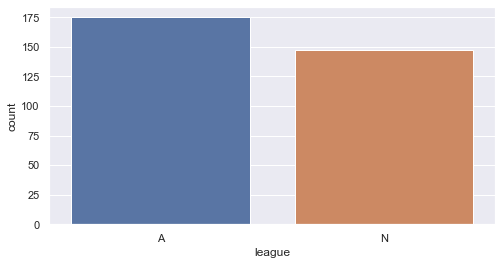

   division  ratio
W       165 51.242
E       157 48.758


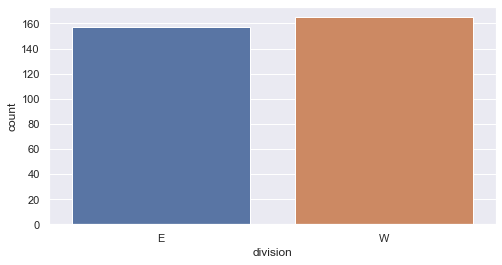

   newleague  ratio
A        176 54.658
N        146 45.342


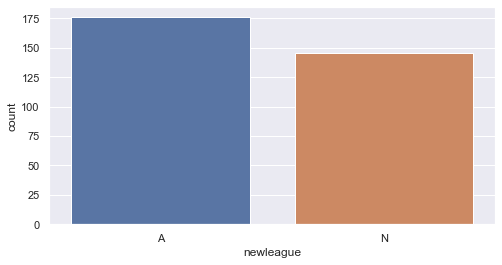

In [486]:
def cat_summary(dataframe, col_name, plot = False):
    print(pd.DataFrame({
        col_name: dataframe[col_name].value_counts(),
        'ratio': 100 * dataframe[col_name].value_counts()/len(dataframe)
    }))

    if plot:
        plt.figure(figsize = (8, 4))
        sns.countplot(x = dataframe[col_name])
        plt.show(block = True)

for col in cat_cols:
    cat_summary(df, col, True)

### **Summary function for numerical columns**


******************-atbat-****************
count   322.000
mean    380.929
std     153.405
min      16.000
5%      161.000
10%     194.100
25%     255.250
50%     379.500
75%     512.000
90%     584.900
99%     658.590
max     687.000
Name: atbat, dtype: float64


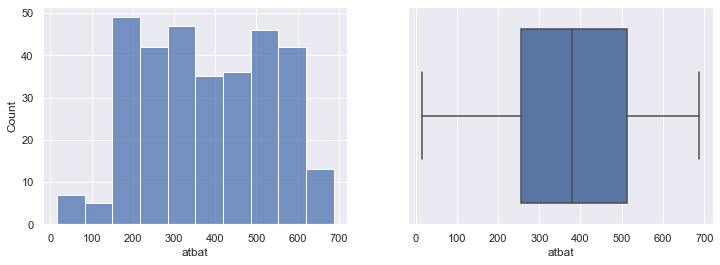


******************-hits-****************
count   322.000
mean    101.025
std      46.455
min       1.000
5%       39.000
10%      45.100
25%      64.000
50%      96.000
75%     137.000
90%     163.000
99%     210.790
max     238.000
Name: hits, dtype: float64


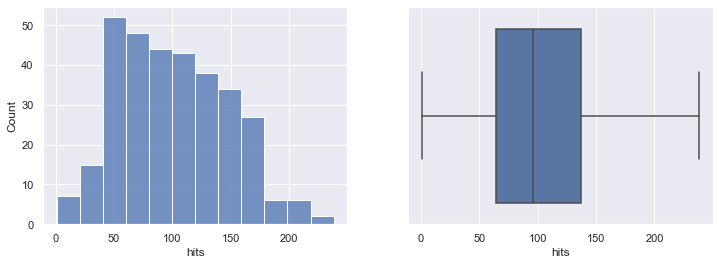


******************-hmrun-****************
count   322.000
mean     10.770
std       8.709
min       0.000
5%        0.000
10%       1.000
25%       4.000
50%       8.000
75%      16.000
90%      24.000
99%      33.000
max      40.000
Name: hmrun, dtype: float64


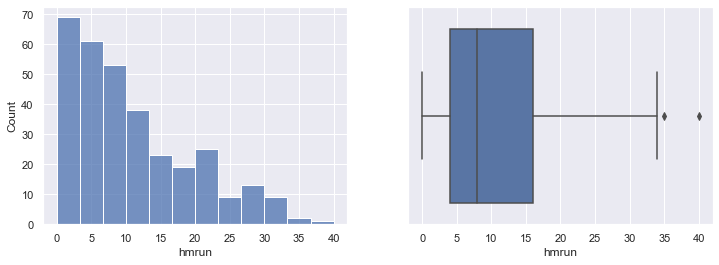


******************-runs-****************
count   322.000
mean     50.910
std      26.024
min       0.000
5%       17.000
10%      20.100
25%      30.250
50%      48.000
75%      69.000
90%      89.000
99%     107.790
max     130.000
Name: runs, dtype: float64


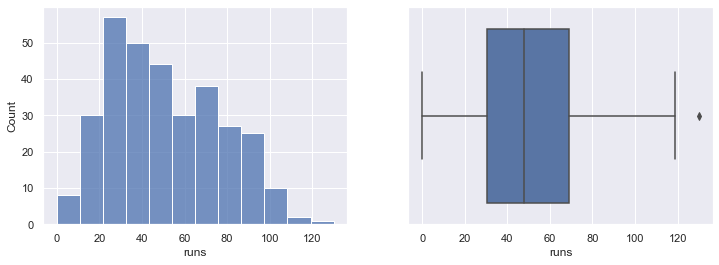


******************-rbi-****************
count   322.000
mean     48.028
std      26.167
min       0.000
5%       14.000
10%      19.000
25%      28.000
50%      44.000
75%      64.750
90%      86.000
99%     112.370
max     121.000
Name: rbi, dtype: float64


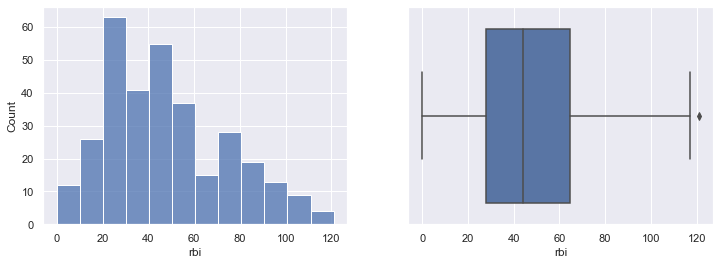


******************-walks-****************
count   322.000
mean     38.742
std      21.639
min       0.000
5%       11.050
10%      15.000
25%      22.000
50%      35.000
75%      53.000
90%      69.900
99%      93.580
max     105.000
Name: walks, dtype: float64


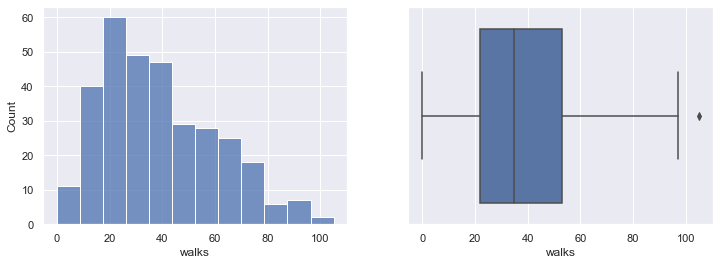


******************-years-****************
count   322.000
mean      7.444
std       4.926
min       1.000
5%        1.000
10%       2.000
25%       4.000
50%       6.000
75%      11.000
90%      15.000
99%      19.790
max      24.000
Name: years, dtype: float64


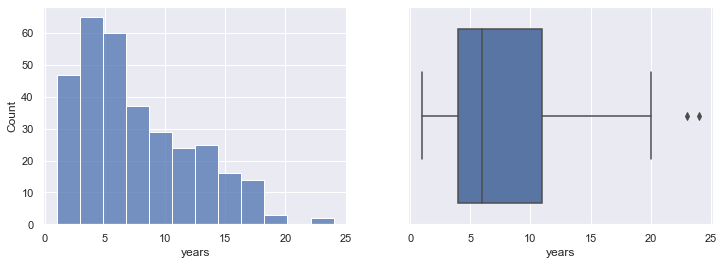


******************-catbat-****************
count     322.000
mean     2648.683
std      2324.206
min        19.000
5%        216.500
10%       342.200
25%       816.750
50%      1928.000
75%      3924.250
90%      6123.400
99%      8749.970
max     14053.000
Name: catbat, dtype: float64


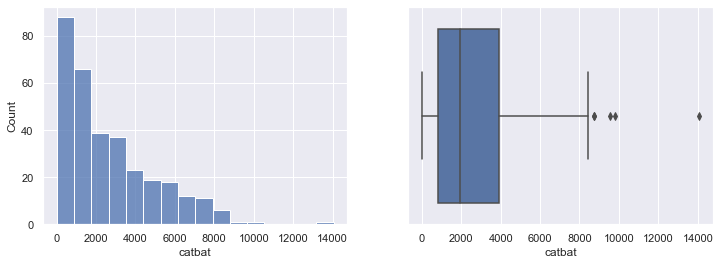


******************-chits-****************
count    322.000
mean     717.571
std      654.473
min        4.000
5%        54.000
10%       86.000
25%      209.000
50%      508.000
75%     1059.250
90%     1659.600
99%     2500.340
max     4256.000
Name: chits, dtype: float64


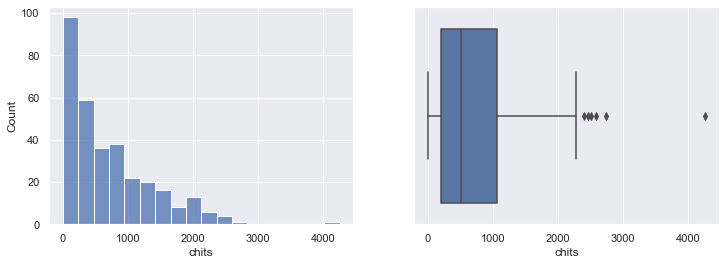


******************-chmrun-****************
count   322.000
mean     69.491
std      86.266
min       0.000
5%        2.000
10%       4.000
25%      14.000
50%      37.500
75%      90.000
90%     194.900
99%     373.120
max     548.000
Name: chmrun, dtype: float64


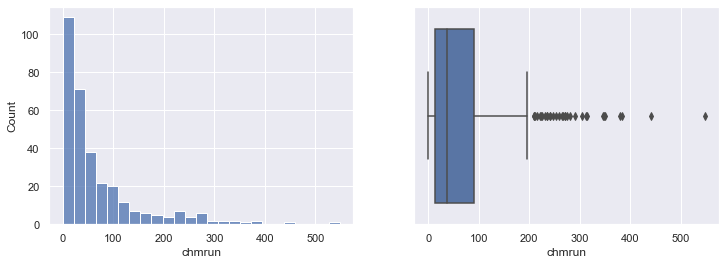


******************-cruns-****************
count    322.000
mean     358.795
std      334.106
min        1.000
5%        27.000
10%       38.100
25%      100.250
50%      247.000
75%      526.250
90%      895.700
99%     1174.370
max     2165.000
Name: cruns, dtype: float64


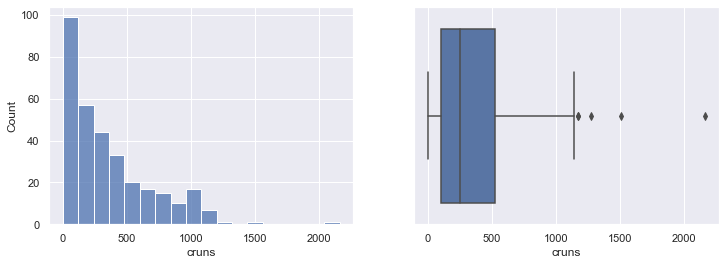


******************-crbi-****************
count    322.000
mean     330.118
std      333.220
min        0.000
5%        22.050
10%       34.100
25%       88.750
50%      220.500
75%      426.250
90%      861.600
99%     1310.850
max     1659.000
Name: crbi, dtype: float64


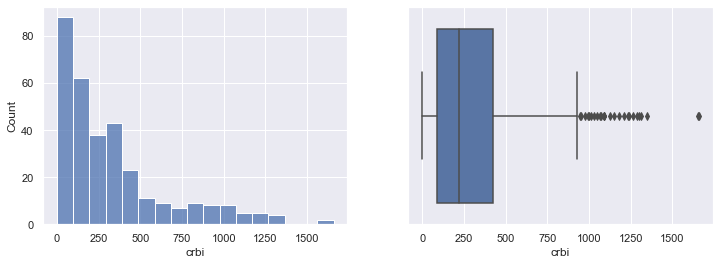


******************-cwalks-****************
count    322.000
mean     260.239
std      267.058
min        0.000
5%        15.050
10%       30.100
25%       67.250
50%      170.500
75%      339.250
90%      643.900
99%     1139.140
max     1566.000
Name: cwalks, dtype: float64


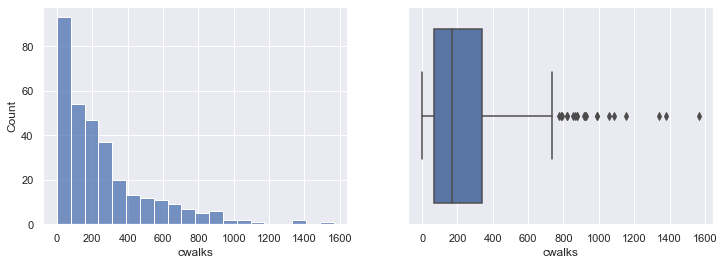


******************-putouts-****************
count    322.000
mean     288.938
std      280.705
min        0.000
5%        33.200
10%       62.200
25%      109.250
50%      212.000
75%      325.000
90%      685.600
99%     1301.190
max     1378.000
Name: putouts, dtype: float64


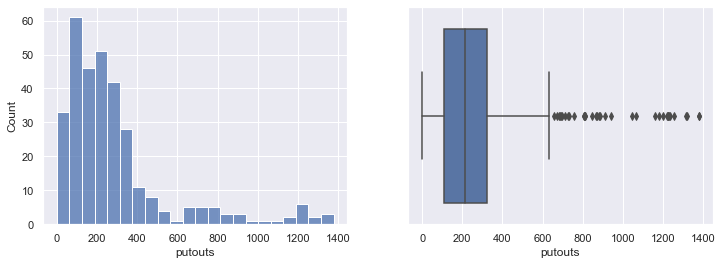


******************-assists-****************
count   322.000
mean    106.913
std     136.855
min       0.000
5%        0.000
10%       2.000
25%       7.000
50%      39.500
75%     166.000
90%     353.300
99%     478.160
max     492.000
Name: assists, dtype: float64


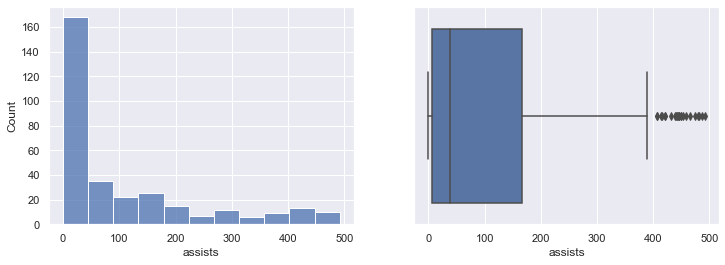


******************-errors-****************
count   322.000
mean      8.040
std       6.368
min       0.000
5%        0.000
10%       1.000
25%       3.000
50%       6.000
75%      11.000
90%      17.000
99%      25.790
max      32.000
Name: errors, dtype: float64


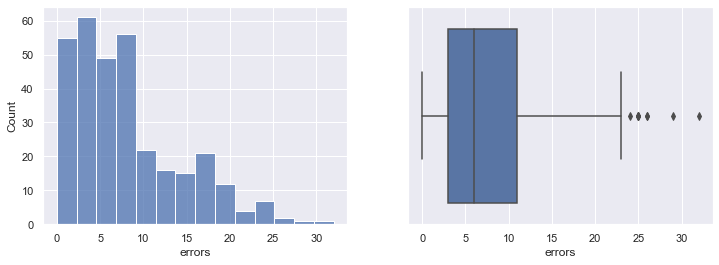


******************-salary-****************
count    263.000
mean     535.926
std      451.119
min       67.500
5%        86.600
10%      100.000
25%      190.000
50%      425.000
75%      750.000
90%     1048.667
99%     2032.887
max     2460.000
Name: salary, dtype: float64


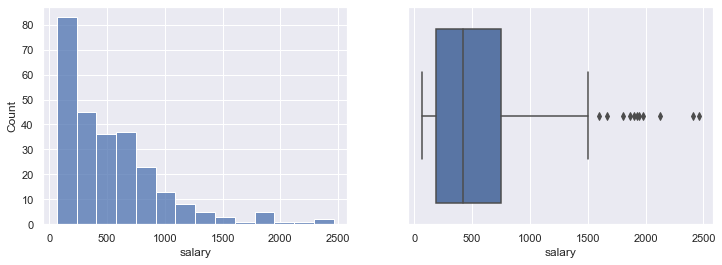

In [487]:
def num_summary(dataframe, col_name, plot = False):
    quantiles = [0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.99]
    print(dataframe[col_name].describe(quantiles).T)

    if plot:
        plt.figure(figsize = (12, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(x = dataframe[col_name])
        plt.subplot(1, 2, 2)
        sns.boxplot(x = dataframe[col_name])
        plt.show()

for col in num_cols:
    print(f'\n******************-{col}-****************')
    num_summary(df, col, True)

### **Analyzing the dependent variable to categorical variables**


***************-LEAGUE-***************
        Target_Mean
league             
A           542.000
N           529.118


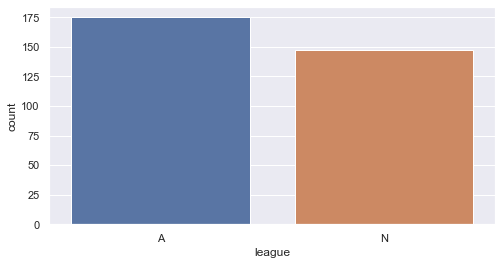


***************-DIVISION-***************
          Target_Mean
division             
E             624.271
W             450.877


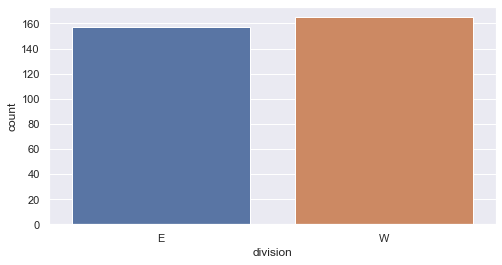


***************-NEWLEAGUE-***************
           Target_Mean
newleague             
A              537.113
N              534.554


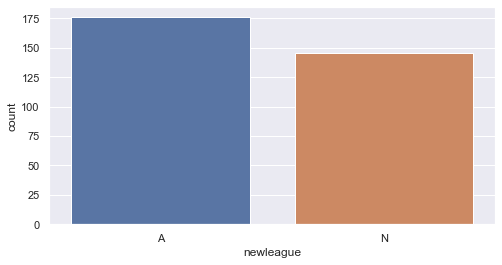

In [488]:
def target_summary_with_cat(dataframe, target, col_name, plot = False):
    print(pd.DataFrame({
        'Target_Mean': dataframe.groupby(col_name)[target].mean()
        }))
    
    if plot:
        plt.figure(figsize = (8, 4))
        sns.countplot(x = dataframe[col_name])
        plt.show(block = True)

for col in cat_cols:
    print(f'\n***************-{col.upper()}-***************')
    target_summary_with_cat(df, 'salary', col, True)

### **Analyzing the dependent variable to numerical variables**


***************-ATBAT-***************
          Target_Mean
salary               
67.500        181.000
68.000        209.000
70.000        248.600
75.000        236.400
80.000        399.000
...               ...
1940.000      514.000
1975.000      677.000
2127.333       20.000
2412.500      618.000
2460.000      495.000

[150 rows x 1 columns]


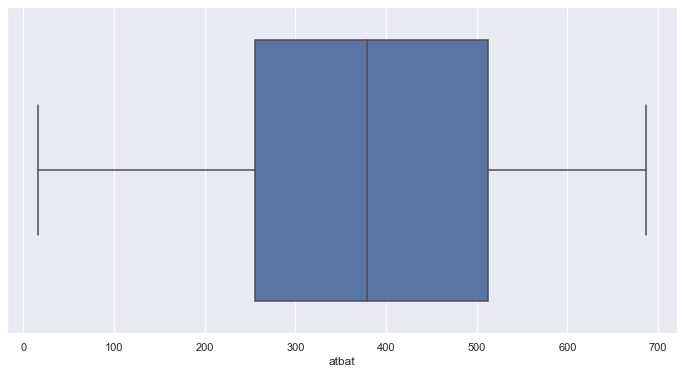


***************-HITS-***************
          Target_Mean
salary               
67.500         41.000
68.000         54.000
70.000         57.400
75.000         58.200
80.000        102.000
...               ...
1940.000      144.000
1975.000      238.000
2127.333        1.000
2412.500      200.000
2460.000      151.000

[150 rows x 1 columns]


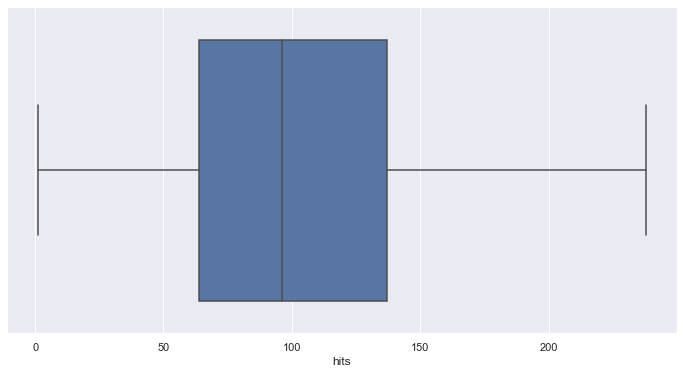


***************-HMRUN-***************
          Target_Mean
salary               
67.500          1.000
68.000          3.000
70.000          3.200
75.000          3.000
80.000          3.000
...               ...
1940.000        0.000
1975.000       31.000
2127.333        0.000
2412.500       20.000
2460.000       17.000

[150 rows x 1 columns]


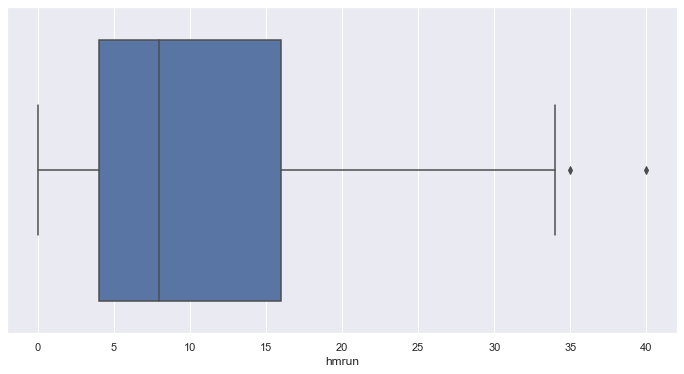


***************-RUNS-***************
          Target_Mean
salary               
67.500         15.000
68.000         25.000
70.000         27.800
75.000         25.200
80.000         56.000
...               ...
1940.000       67.000
1975.000      117.000
2127.333        0.000
2412.500       98.000
2460.000       61.000

[150 rows x 1 columns]


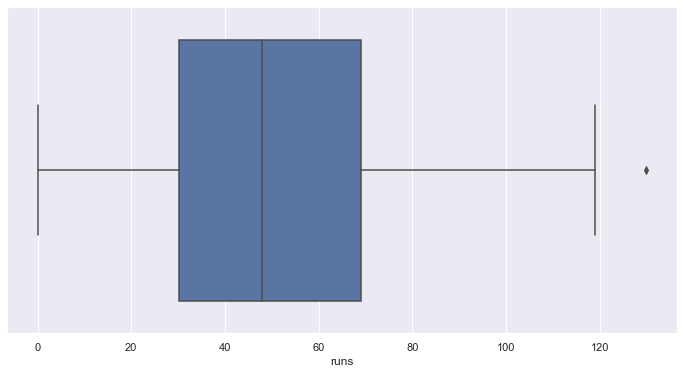


***************-RBI-***************
          Target_Mean
salary               
67.500         21.000
68.000         14.000
70.000         22.400
75.000         22.800
80.000         34.000
...               ...
1940.000       54.000
1975.000      113.000
2127.333        0.000
2412.500      110.000
2460.000       84.000

[150 rows x 1 columns]


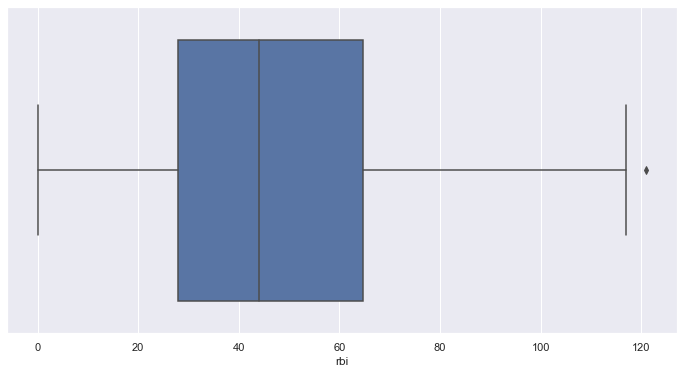


***************-WALKS-***************
          Target_Mean
salary               
67.500         33.000
68.000         12.000
70.000         22.200
75.000         21.600
80.000         34.000
...               ...
1940.000       79.000
1975.000       53.000
2127.333        0.000
2412.500       62.000
2460.000       78.000

[150 rows x 1 columns]


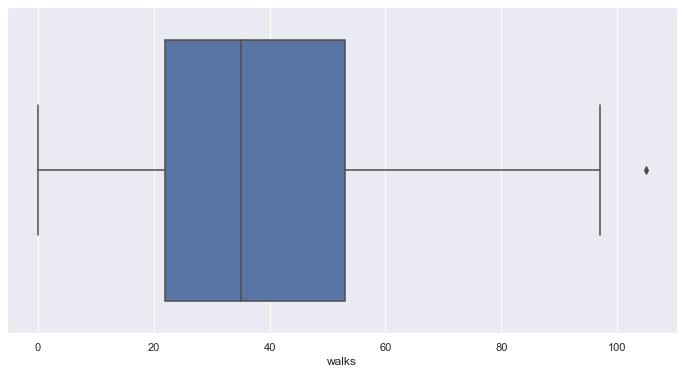


***************-YEARS-***************
          Target_Mean
salary               
67.500          2.000
68.000          1.000
70.000          1.400
75.000          2.000
80.000          5.000
...               ...
1940.000        9.000
1975.000        5.000
2127.333        2.000
2412.500       13.000
2460.000       10.000

[150 rows x 1 columns]


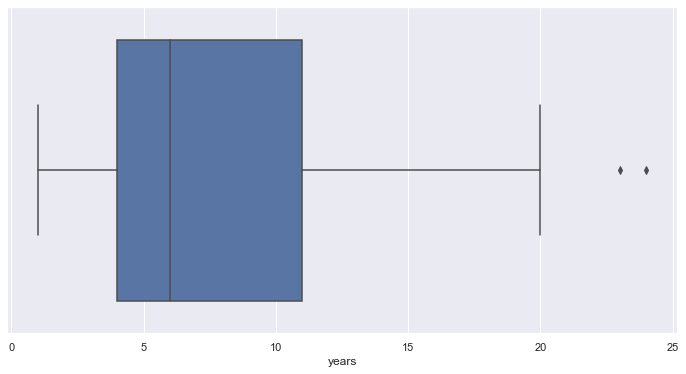


***************-CATBAT-***************
          Target_Mean
salary               
67.500        232.000
68.000        209.000
70.000        256.800
75.000        309.200
80.000        670.000
...               ...
1940.000     4739.000
1975.000     2223.000
2127.333       41.000
2412.500     7127.000
2460.000     5624.000

[150 rows x 1 columns]


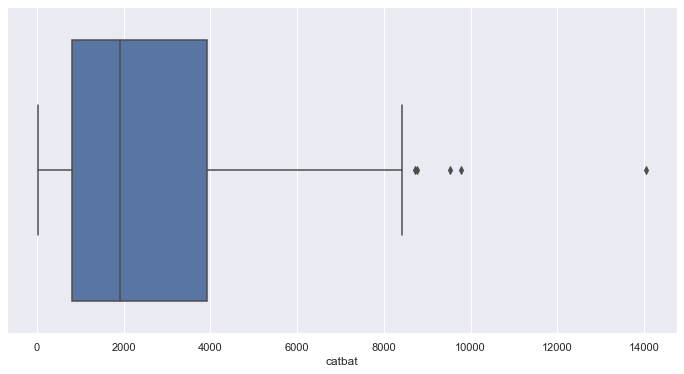


***************-CHITS-***************
          Target_Mean
salary               
67.500         50.000
68.000         54.000
70.000         59.600
75.000         73.600
80.000        167.000
...               ...
1940.000     1169.000
1975.000      737.000
2127.333        9.000
2412.500     2163.000
2460.000     1679.000

[150 rows x 1 columns]


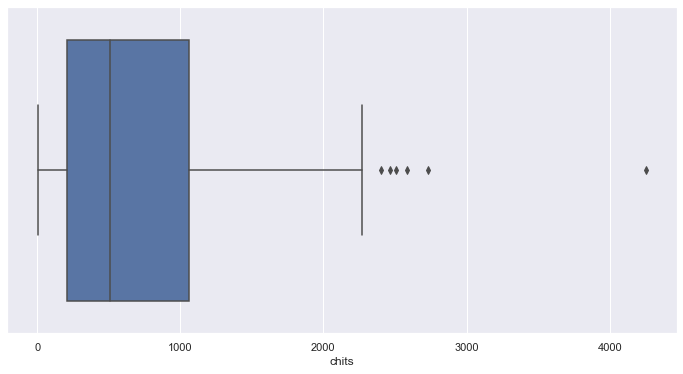


***************-CHMRUN-***************
          Target_Mean
salary               
67.500          4.000
68.000          3.000
70.000          3.200
75.000          3.600
80.000          4.000
...               ...
1940.000       13.000
1975.000       93.000
2127.333        2.000
2412.500      351.000
2460.000      275.000

[150 rows x 1 columns]


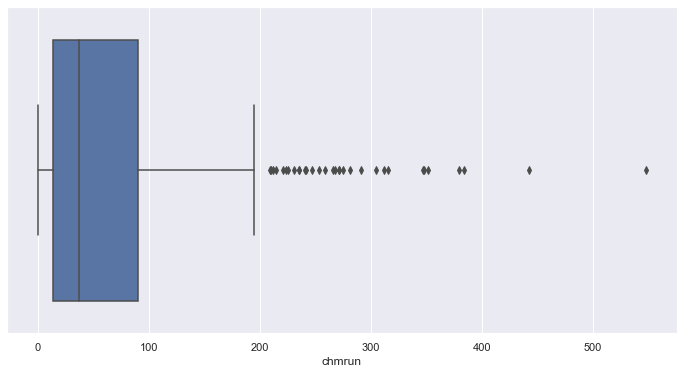


***************-CRUNS-***************
          Target_Mean
salary               
67.500         20.000
68.000         25.000
70.000         29.600
75.000         33.000
80.000         89.000
...               ...
1940.000      583.000
1975.000      349.000
2127.333        6.000
2412.500     1104.000
2460.000      884.000

[150 rows x 1 columns]


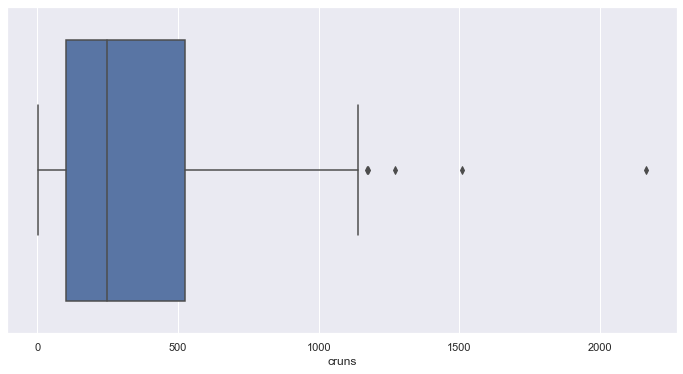


***************-CRBI-***************
          Target_Mean
salary               
67.500         29.000
68.000         14.000
70.000         23.200
75.000         27.000
80.000         48.000
...               ...
1940.000      374.000
1975.000      401.000
2127.333        7.000
2412.500     1289.000
2460.000     1015.000

[150 rows x 1 columns]


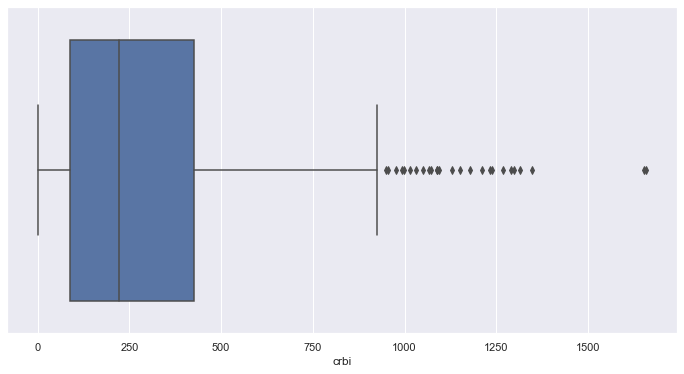


***************-CWALKS-***************
          Target_Mean
salary               
67.500         45.000
68.000         12.000
70.000         23.600
75.000         25.600
80.000         54.000
...               ...
1940.000      528.000
1975.000      171.000
2127.333        4.000
2412.500      564.000
2460.000      709.000

[150 rows x 1 columns]


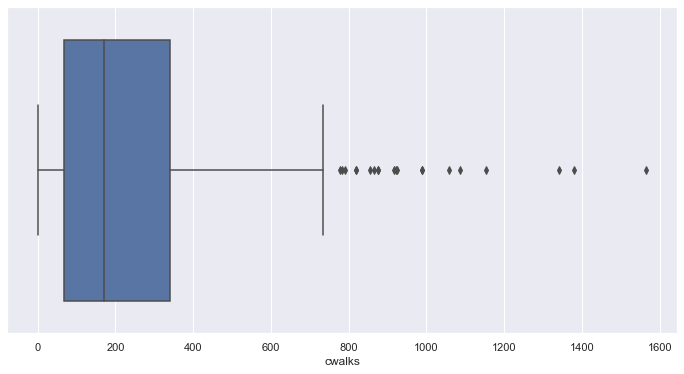


***************-PUTOUTS-***************
          Target_Mean
salary               
67.500        326.000
68.000        102.000
70.000         86.400
75.000        210.200
80.000        211.000
...               ...
1940.000      229.000
1975.000     1377.000
2127.333       78.000
2412.500      330.000
2460.000     1045.000

[150 rows x 1 columns]


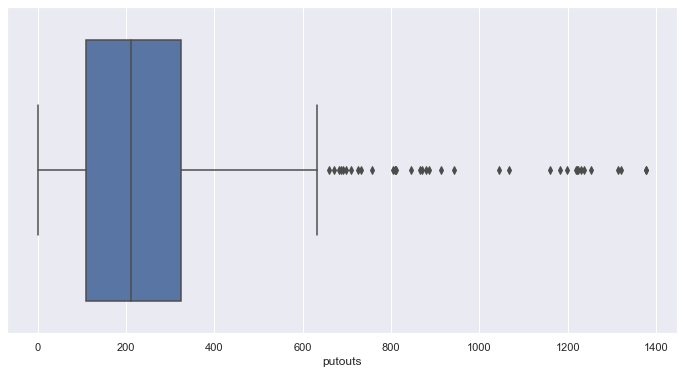


***************-ASSISTS-***************
          Target_Mean
salary               
67.500         29.000
68.000          6.000
70.000         82.200
75.000        110.600
80.000          9.000
...               ...
1940.000      453.000
1975.000      100.000
2127.333      220.000
2412.500       16.000
2460.000       88.000

[150 rows x 1 columns]


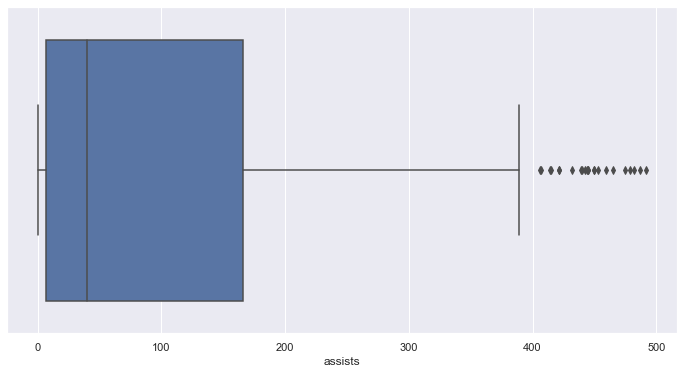


***************-ERRORS-***************
          Target_Mean
salary               
67.500          5.000
68.000          3.000
70.000         12.600
75.000          8.600
80.000          3.000
...               ...
1940.000       15.000
1975.000        6.000
2127.333        6.000
2412.500        8.000
2460.000       13.000

[150 rows x 1 columns]


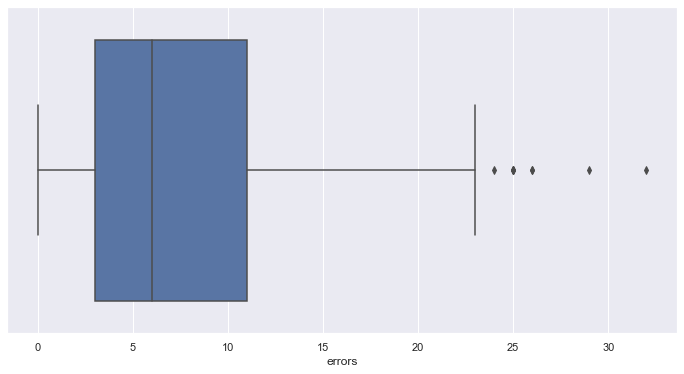


***************-SALARY-***************
          Target_Mean
salary               
67.500         67.500
68.000         68.000
70.000         70.000
75.000         75.000
80.000         80.000
...               ...
1940.000     1940.000
1975.000     1975.000
2127.333     2127.333
2412.500     2412.500
2460.000     2460.000

[150 rows x 1 columns]


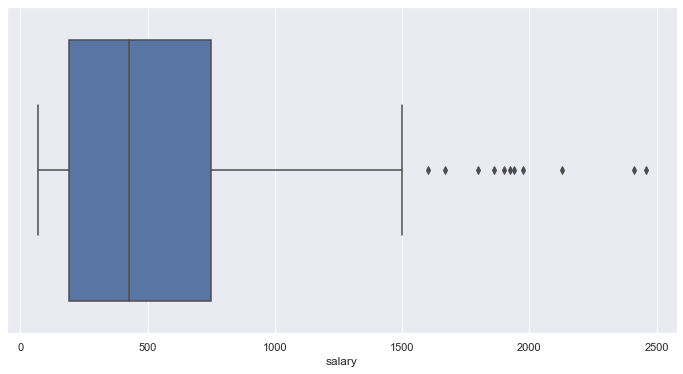

In [489]:
def target_summary_with_num(dataframe, target, col_name, plot = False):
    print(pd.DataFrame({
        'Target_Mean': dataframe.groupby(target)[col_name].mean()
        }))
    
    if plot:
        plt.figure(figsize = (12, 6))
        sns.boxplot(x = dataframe[col_name])
        plt.show(block = True)

for col in num_cols:
    print(f'\n***************-{col.upper()}-***************')
    target_summary_with_num(df, 'salary', col, True)

### **Correlation Analysis**

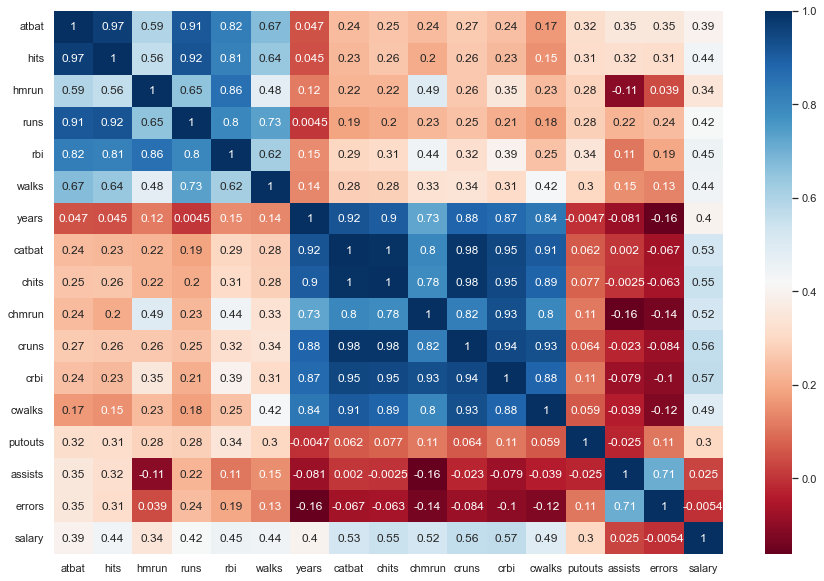

In [490]:
def high_correlation_cols(dataframe, plot = False, corr_th = 0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()     # Does not matter - or + correlation and easy to use
    upper_triangle_matrix  = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k = 1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        plt.figure(figsize = (15, 10))
        sns.heatmap(corr, annot = True, cmap = 'RdBu')
        plt.show()
    
    return drop_list

df = dataset()
df.columns = [col.lower() for col in df.columns]
drop_list = high_correlation_cols(df, plot = True)

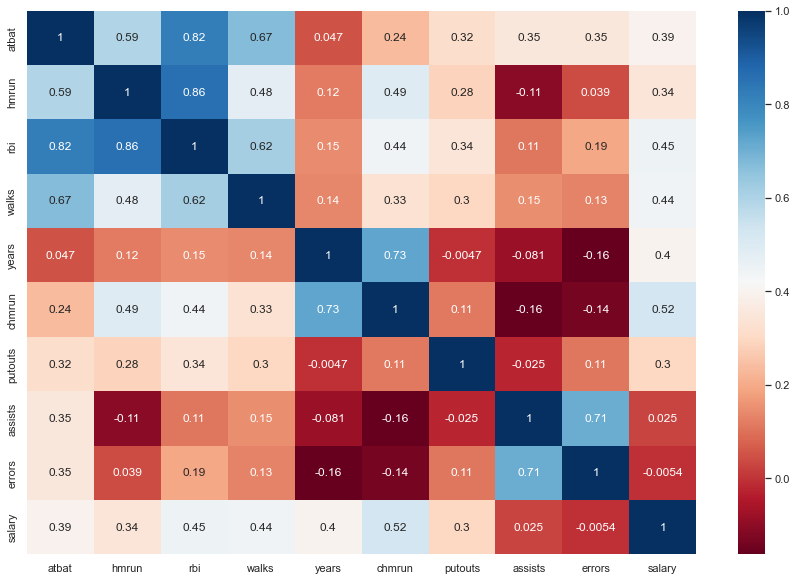

[]

In [491]:
high_correlation_cols(df.drop(drop_list, axis = 1), plot = True)

## **Feature Engineering**

### **Missin Data Analysis**

#### **Getting columns including zero-one**

In [492]:
df = dataset()
df.columns = [col.lower() for col in df.columns]
zero_one_columns = [col for col in df.columns if (((df[col].min() == 0) | (df[col].min() == 1)) and col not in ["hmrun", "years", "assists", "errors"])]
zero_one_columns

['hits',
 'runs',
 'rbi',
 'walks',
 'chmrun',
 'cruns',
 'crbi',
 'cwalks',
 'putouts']

#### **Replacing each of the variables 0 and 1 in observation units with NaN**

In [493]:
for col in zero_one_columns:
    df[col] = np.where(((df[col] == 0) | (df[col] == 1)), np.nan, df[col])

##### **Missing Data**

In [494]:
df.isnull().sum()

atbat         0
hits          1
hmrun         0
runs          4
rbi           3
walks         5
years         0
catbat        0
chits         0
chmrun       16
cruns         1
crbi          1
cwalks        2
league        0
division      0
putouts      15
assists       0
errors        0
salary       59
newleague     0
dtype: int64

### **Defining a function to get misssing data table**

In [495]:
def missing_values_table(dataframe, na_name = False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending = False)
    ratio = (dataframe[na_columns].isnull().sum()/dataframe.shape[0] * 100).sort_values(ascending = False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis = 1, keys = ['n_miss', 'ratio'])
    print(missing_df, end = '\n')

    if na_name:
        return na_columns
    
na_columns = missing_values_table(df, na_name = True)

         n_miss  ratio
salary       59 18.320
chmrun       16  4.970
putouts      15  4.660
walks         5  1.550
runs          4  1.240
rbi           3  0.930
cwalks        2  0.620
hits          1  0.310
cruns         1  0.310
crbi          1  0.310


#### **Filling the missing data in target variable with median**

In [496]:
df.loc[df['salary'].isnull(), 'salary'] = df['salary'].median()

#### **Defining a function to examine the relationship of missing data with the dependent variable**

In [497]:
def missing_vs_target(dataframe, target, na_cols):
    temp_df = dataframe.copy()
    for col in na_cols:
        temp_df[col + '_na_flag'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains('_na_')].columns
    for col in na_flags:
        print(pd.DataFrame({
            'Target_mean': temp_df.groupby(col)[target].mean(),
            'Count': temp_df.groupby(col)[target].count()
        }), end = '\n\n')

missing_vs_target(df, 'salary', na_columns)

              Target_mean  Count
hits_na_flag                    
0                 510.580    321
1                2127.333      1

              Target_mean  Count
runs_na_flag                    
0                 511.387    318
1                 850.583      4

             Target_mean  Count
rbi_na_flag                    
0                511.117    319
1                992.444      3

               Target_mean  Count
walks_na_flag                    
0                  510.098    317
1                  864.467      5

                Target_mean  Count
chmrun_na_flag                    
0                   526.556    306
1                   306.094     16

               Target_mean  Count
cruns_na_flag                    
0                  515.883    321
1                  425.000      1

              Target_mean  Count
crbi_na_flag                    
0                 515.883    321
1                 425.000      1

                Target_mean  Count
cwalks_na_flag        

#### **Filling the missing data with median**

In [498]:
for col in zero_one_columns:
    df.loc[df[col].isnull(), col] = df[col].median()
df.isnull().sum()

atbat        0
hits         0
hmrun        0
runs         0
rbi          0
walks        0
years        0
catbat       0
chits        0
chmrun       0
cruns        0
crbi         0
cwalks       0
league       0
division     0
putouts      0
assists      0
errors       0
salary       0
newleague    0
dtype: int64

### **Outliers**

#### **Defining a function to get outliers**

In [499]:
def outlier_threshold(dataframe, col_name, q1 = 0.10, q3 = 0.90):
    quantile1 = dataframe[col_name].quantile(q1)
    quantile3 = dataframe[col_name].quantile(q3)
    iqr = quantile3 - quantile1
    down_limit = quantile1 - 1.5 * iqr
    up_limit = quantile3 + 1.5 * iqr

    return down_limit, up_limit

#### **Defining a function to ask whether there is an outlier or not**

In [500]:
def check_outlier(dataframe, col_name):
    down_limit, up_limit = outlier_threshold(dataframe, col_name)
    if dataframe[(dataframe[col_name] < down_limit) | (dataframe[col_name] > up_limit)].any(axis = None):
        return True
    else:
        return False

#### **Defining a function to replace the outliers with thresholds**

In [501]:
def replace_with_threshold(dataframe, col_name):
    down_limit, up_limit = outlier_threshold(dataframe, col_name)
    dataframe.loc[(dataframe[col_name] < down_limit), col_name] = down_limit
    dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit

In [502]:
for col in num_cols:
    print(col, check_outlier(df, col))

atbat False
hits False
hmrun False
runs False
rbi False
walks False
years False
catbat False
chits True
chmrun True
cruns False
crbi False
cwalks True
putouts False
assists False
errors False
salary True


In [503]:
for col in num_cols:
    replace_with_threshold(df, col)

In [504]:
for col in num_cols:
    print(col, check_outlier(df, col))

atbat False
hits False
hmrun False
runs False
rbi False
walks False
years False
catbat False
chits False
chmrun False
cruns False
crbi False
cwalks False
putouts False
assists False
errors False
salary False


## **Feature Extraction**

In [505]:
df.columns

Index(['atbat', 'hits', 'hmrun', 'runs', 'rbi', 'walks', 'years', 'catbat', 'chits', 'chmrun', 'cruns', 'crbi', 'cwalks', 'league', 'division', 'putouts', 'assists', 'errors', 'salary', 'newleague'], dtype='object')

#### **Effect of interaction on salary**

In [506]:
df['new_hmrun_atbat'] = df['hmrun'] * df['atbat']
df['new_atbat_rbi'] = df['atbat'] * df['rbi']
df['new_hmrun_rbi'] = df['hmrun'] * df['rbi']
df['new_atbat_walks'] = df['atbat'] * df['walks']
df['new_hmrun_walks'] = df['hmrun'] * df['walks']
df['new_rbi_walks'] = df['rbi'] * df['walks']
df['nwe_hmrun_chumrun'] = df['hmrun'] * df['chmrun']
df['new_rbi_chumrun'] = df['rbi'] * df['chmrun']
df['new_years_chumrun'] = df['years'] * df['chmrun']
df['new_assists_errors'] = df['assists'] * df['errors']

#### **Experience to year**

In [507]:
df['new_experience'] = pd.cut(x = df['years'], bins = [0, 2, 8, df.years.max()], 
                        labels = ['low_experience', 'middle_experience', 'high_experience'])

#### **Total number of hits**

In [508]:
df['new_sum_hit'] = df['atbat'] + df['hits'] + df['hmrun']

#### **Total number of hits during career**

In [509]:
df['new_sum_ball_hits'] = df['catbat'] + df['chits']

#### **Total number of the best scores**

In [510]:
df['new_total_scores'] = df['chmrun'] + df['cruns']

#### **Total number of players running**

In [511]:
df['new_total_runners'] = df['rbi'] + df['crbi']

#### **Total number of errors**

In [512]:
df['new_total_errors'] = df['walks'] + df['cwalks']

#### **Helping level**

In [513]:
labels = ['bad_level', 'middle_level', 'high_level']
df['new_putout_level'] = pd.qcut(df['putouts'], 3, labels = labels)

#### **Relationship between league and assists**

In [514]:
df.loc[(df['league'] == 'A') & (df['assists'] <= 39.5), 'new_league_cat'] = 'low_assists_level_A'
df.loc[(df['league'] == 'A') & (df['assists'] > 39.5), 'new_league_cat'] = 'high_assists_level_A'
df.loc[(df['league'] == 'N') & (df['assists'] <= 39.5), 'new_league_cat'] = 'low_assists_level_N'
df.loc[(df['league'] == 'N') & (df['assists'] > 39.5), 'new_league_cat'] = 'high_assists_level_N'
df.loc[(df['newleague'] == 'A') & (df['assists'] <= 39.5), 'new_newleague_cat'] = 'low_assists_level_A'
df.loc[(df['newleague'] == 'A') & (df['assists'] > 39.5), 'new_newleague_cat'] = 'high_assists_level_A'
df.loc[(df['newleague'] == 'N') & (df['assists'] <= 39.5), 'new_newleague_cat'] = 'low_assists_level_N'
df.loc[(df['newleague'] == 'N') & (df['assists'] > 39.5), 'new_newleague_cat'] = 'high_assists_level_N'

#### **Relationship between division and assists**

In [515]:
df.loc[(df['division'] == 'E') & (df['assists'] <= 39.5), 'new_division_cat'] = 'low_assists_level_E'
df.loc[(df['division'] == 'E') & (df['assists'] > 39.5), 'new_division_cat'] = 'high_assists_level_E'
df.loc[(df['division'] == 'W') & (df['assists'] <= 39.5), 'new_division_cat'] = 'low_assists_level_W'
df.loc[(df['division'] == 'W') & (df['assists'] > 39.5), 'new_division_cat'] = 'high_assists_level_W'

#### **Relationship between league and errors**

In [516]:
df.loc[(df['league'] == 'A') & (df['errors'] <= df['errors'].median()), 'new_error_cat'] = 'low_error_A'
df.loc[(df['league'] == 'A') & (df['errors'] > df['errors'].median()), 'new_error_cat'] = 'high_error_A'
df.loc[(df['league'] == 'N') & (df['errors'] <= df['errors'].median()), 'new_error_cat'] = 'low_error_N'
df.loc[(df['league'] == 'N') & (df['errors'] > df['errors'].median()), 'new_error_cat'] = 'high_error_N'
df.loc[(df['newleague'] == 'A') & (df['errors'] <= df['errors'].median()), 'new_newerror_cat'] = 'low_error_A'
df.loc[(df['newleague'] == 'A') & (df['errors'] > df['errors'].median()), 'new_newerror_cat'] = 'high_error_A'
df.loc[(df['newleague'] == 'N') & (df['errors'] <= df['errors'].median()), 'new_newerror_cat'] = 'low_error_N'
df.loc[(df['newleague'] == 'N') & (df['errors'] > df['errors'].median()), 'new_newerror_cat'] = 'high_error_N'

#### **Relationship between division and errors**

In [517]:
df.loc[(df['division'] == 'E') & (df['errors'] <= df['errors'].median()), 'new_division_error'] = 'low_error_E'
df.loc[(df['division'] == 'E') & (df['errors'] > df['errors'].median()), 'new_division_error'] = 'high_error_E'
df.loc[(df['division'] == 'W') & (df['errors'] <= df['errors'].median()), 'new_division_error'] = 'low_error_W'
df.loc[(df['division'] == 'W') & (df['errors'] > df['errors'].median()), 'new_division_error'] = 'high_error_W'

#### **Relationship between division and walks/cwalks**

In [518]:
df.loc[(df['division'] == 'E') & (df['walks'] <= df['walks'].median()), 'new_division_walks'] = 'low_walks_E'
df.loc[(df['division'] == 'E') & (df['walks'] > df['walks'].median()), 'new_division_walks'] = 'high_walks_E'
df.loc[(df['division'] == 'W') & (df['walks'] <= df['walks'].median()), 'new_division_walks'] = 'low_walks_W'
df.loc[(df['division'] == 'W') & (df['walks'] > df['walks'].median()), 'new_division_walks'] = 'high_walks_W'
df.loc[(df['division'] == 'E') & (df['cwalks'] <= df['cwalks'].median()), 'new_division_cwalks'] = 'low_cwalks_E'
df.loc[(df['division'] == 'E') & (df['cwalks'] > df['cwalks'].median()), 'new_division_cwalks'] = 'high_cwalks_E'
df.loc[(df['division'] == 'W') & (df['cwalks'] <= df['cwalks'].median()), 'new_division_cwalks'] = 'low_cwalks_W'
df.loc[(df['division'] == 'W') & (df['cwalks'] > df['cwalks'].median()), 'new_division_cwalks'] = 'high_cwalks_W'

#### **Relationship between league and walks/cwalks**

In [519]:
df.loc[(df['league'] == 'A') & (df['walks'] <= df['walks'].median()), 'new_league_walks'] = 'low_walks_A'
df.loc[(df['league'] == 'A') & (df['walks'] > df['walks'].median()), 'new_league_walks'] = 'high_walks_A'
df.loc[(df['league'] == 'N') & (df['walks'] <= df['walks'].median()), 'new_league_walks'] = 'low_walks_N'
df.loc[(df['league'] == 'N') & (df['walks'] > df['walks'].median()), 'new_league_walks'] = 'high_walks_N'
df.loc[(df['league'] == 'A') & (df['cwalks'] <= df['cwalks'].median()), 'new_league_cwalks'] = 'low_cwalks_A'
df.loc[(df['league'] == 'A') & (df['cwalks'] > df['cwalks'].median()), 'new_league_cwalks'] = 'high_cwalks_A'
df.loc[(df['league'] == 'N') & (df['cwalks'] <= df['cwalks'].median()), 'new_league_cwalks'] = 'low_cwalks_N'
df.loc[(df['league'] == 'N') & (df['cwalks'] > df['cwalks'].median()), 'new_league_cwalks'] = 'high_cwalks_N'

#### **Relationship between newleague and walks/cwalks**

In [520]:
df.loc[(df['newleague'] == 'A') & (df['walks'] <= df['walks'].median()), 'new_newleague_walks'] = 'low_walks_A'
df.loc[(df['newleague'] == 'A') & (df['walks'] > df['walks'].median()), 'new_newleague_walks'] = 'high_walks_A'
df.loc[(df['newleague'] == 'N') & (df['walks'] <= df['walks'].median()), 'new_newleague_walks'] = 'low_walks_N'
df.loc[(df['newleague'] == 'N') & (df['walks'] > df['walks'].median()), 'new_newleague_walks'] = 'high_walks_N'
df.loc[(df['newleague'] == 'A') & (df['cwalks'] <= df['cwalks'].median()), 'new_newleague_cwalks'] = 'low_cwalks_A'
df.loc[(df['newleague'] == 'A') & (df['cwalks'] > df['cwalks'].median()), 'new_newleague_cwalks'] = 'high_cwalks_A'
df.loc[(df['newleague'] == 'N') & (df['cwalks'] <= df['cwalks'].median()), 'new_newleague_cwalks'] = 'low_cwalks_N'
df.loc[(df['newleague'] == 'N') & (df['cwalks'] > df['cwalks'].median()), 'new_newleague_cwalks'] = 'high_cwalks_N'

#### **Checking outliers**

In [521]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations : 322
Variables: 49
Number of categoric columns: 17
Number of numeric columns: 32
Number of categoric but cardinal columns: 0
Number of numeric but categoric columns: 0


In [522]:
for col in num_cols:
    print(col, check_outlier(df, col))

atbat False
hits False
hmrun False
runs False
rbi False
walks False
years False
catbat False
chits False
chmrun False
cruns False
crbi False
cwalks False
putouts False
assists False
errors False
salary False
new_hmrun_atbat False
new_atbat_rbi False
new_hmrun_rbi False
new_atbat_walks False
new_hmrun_walks False
new_rbi_walks False
nwe_hmrun_chumrun True
new_rbi_chumrun True
new_years_chumrun True
new_assists_errors True
new_sum_hit False
new_sum_ball_hits False
new_total_scores False
new_total_runners False
new_total_errors False


In [523]:
for col in num_cols:
    replace_with_threshold(df, col)

In [524]:
for col in num_cols:
    print(col, check_outlier(df, col))

atbat False
hits False
hmrun False
runs False
rbi False
walks False
years False
catbat False
chits False
chmrun False
cruns False
crbi False
cwalks False
putouts False
assists False
errors False
salary False
new_hmrun_atbat False
new_atbat_rbi False
new_hmrun_rbi False
new_atbat_walks False
new_hmrun_walks False
new_rbi_walks False
nwe_hmrun_chumrun False
new_rbi_chumrun False
new_years_chumrun False
new_assists_errors False
new_sum_hit False
new_sum_ball_hits False
new_total_scores False
new_total_runners False
new_total_errors False


In [525]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


### **Label encoding**

In [526]:
def label_encoder(dataframe, binary_cols):
    label_encoder = LabelEncoder()
    dataframe[binary_cols] = label_encoder.fit_transform(dataframe[binary_cols])

    return dataframe

In [527]:
binary_cols = [col for col in df.columns if df[col].dtypes in ['category', 'object', 'bool'] and df[col].nunique() == 2]
binary_cols

['league', 'division', 'newleague']

In [528]:
for col in binary_cols:
    label_encoder(df, col)

In [529]:
df.head()

,atbat,hits,hmrun,runs,rbi,walks,years,catbat,chits,chmrun,cruns,crbi,cwalks,league,division,putouts,assists,errors,salary,newleague,new_hmrun_atbat,new_atbat_rbi,new_hmrun_rbi,new_atbat_walks,new_hmrun_walks,new_rbi_walks,nwe_hmrun_chumrun,new_rbi_chumrun,new_years_chumrun,new_assists_errors,new_experience,new_sum_hit,new_sum_ball_hits,new_total_scores,new_total_runners,new_total_errors,new_putout_level,new_league_cat,new_newleague_cat,new_division_cat,new_error_cat,new_newerror_cat,new_division_error,new_division_walks,new_division_cwalks,new_league_walks,new_league_cwalks,new_newleague_walks,new_newleague_cwalks
0,293.000,66.000,1.000,30.000,29.000,14.000,1.000,293.000,66.000,40.000,30.000,29.000,14.000,0,0,446.000,33.000,20,425.000,0,293.000,8497.000,29.000,4102.000,14.000,406.000,40.000,1160.000,40.000,660.000,low_experience,360.000,359.000,70.000,58.000,28.000,high_level,low_assists_level_A,low_assists_level_A,low_assists_level_E,high_error_A,high_error_A,high_error_E,low_walks_E,low_cwalks_E,low_walks_A,low_cwalks_A,low_walks_A,low_cwalks_A
1,315.000,81.000,7.000,24.000,38.000,39.000,14.000,3449.000,835.000,69.000,321.000,414.000,375.000,1,1,632.000,43.000,10,475.000,1,2205.000,11970.000,266.000,12285.000,273.000,1482.000,483.000,2622.000,966.000,430.000,high_experience,403.000,4284.000,390.000,452.000,414.000,high_level,high_assists_level_N,high_assists_level_N,high_assists_level_W,high_error_N,high_error_N,high_error_W,high_walks_W,high_cwalks_W,high_walks_N,high_cwalks_N,high_walks_N,high_cwalks_N
2,479.000,130.000,18.000,66.000,72.000,76.000,3.000,1624.000,457.000,63.000,224.000,266.000,263.000,0,1,880.000,82.000,14,480.000,0,8622.000,34488.000,1296.000,36404.000,1368.000,5472.000,1134.000,4536.000,189.000,1148.000,middle_experience,627.000,2081.000,287.000,338.000,339.000,high_level,high_assists_level_A,high_assists_level_A,high_assists_level_W,high_error_A,high_error_A,high_error_W,high_walks_W,high_cwalks_W,high_walks_A,high_cwalks_A,high_walks_A,high_cwalks_A
3,496.000,141.000,20.000,65.000,78.000,37.000,11.000,5628.000,1575.000,225.000,828.000,838.000,354.000,1,0,200.000,11.000,3,500.000,1,9920.000,38688.000,1560.000,18352.000,740.000,2886.000,4500.000,17550.000,2475.000,33.000,high_experience,657.000,7203.000,1053.000,916.000,391.000,middle_level,low_assists_level_N,low_assists_level_N,low_assists_level_E,low_error_N,low_error_N,low_error_E,high_walks_E,high_cwalks_E,high_walks_N,high_cwalks_N,high_walks_N,high_cwalks_N
4,321.000,87.000,10.000,39.000,42.000,30.000,2.000,396.000,101.000,12.000,48.000,46.000,33.000,1,0,805.000,40.000,4,91.500,1,3210.000,13482.000,420.000,9630.000,300.000,1260.000,120.000,504.000,24.000,160.000,low_experience,418.000,497.000,60.000,88.000,63.000,high_level,high_assists_level_N,high_assists_level_N,high_assists_level_E,low_error_N,low_error_N,low_error_E,low_walks_E,low_cwalks_E,low_walks_N,low_cwalks_N,low_walks_N,low_cwalks_N


### **Rare Encoding**

In [530]:
def rare_analyser(dataframe, target, categoric_cols):
    for col in categoric_cols:
        print(col, ':', len(dataframe[col].value_counts()))
        print(pd.DataFrame({
            'count': dataframe[col].value_counts(),
            'ratio': dataframe[col].value_counts()/len(dataframe),
            'target_mean': dataframe.groupby(col)[target].mean()
        }), end = '\n\n')

In [531]:
rare_analyser(df, 'salary', cat_cols)

league : 2
   count  ratio  target_mean
0    175  0.543      516.660
1    147  0.457      512.827

division : 2
   count  ratio  target_mean
0    157  0.488      587.315
1    165  0.512      446.015

newleague : 2
   count  ratio  target_mean
0    176  0.547      513.554
1    146  0.453      516.545

new_experience : 3
                   count  ratio  target_mean
low_experience        47  0.146      232.507
middle_experience    162  0.503      476.907
high_experience      113  0.351      686.851

new_putout_level : 3
              count  ratio  target_mean
bad_level       108  0.335      422.883
middle_level    107  0.332      469.456
high_level      107  0.332      653.251

new_league_cat : 4
                      count  ratio  target_mean
high_assists_level_A     83  0.258      533.146
high_assists_level_N     78  0.242      553.191
low_assists_level_A      92  0.286      501.786
low_assists_level_N      69  0.214      467.198

new_newleague_cat : 4
                      count  ratio

Nadir deger olmadigindan, rare_encoder fonksiyonu calistirilmamistir.

### **One Hot Encoding**

In [532]:
def one_hot_encoder(dataframe, categorical_cols, drop_first = True):
    dataframe = pd.get_dummies(dataframe, columns = categorical_cols, drop_first = drop_first)
    return dataframe

In [533]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
ohe_cols

['new_experience',
 'new_putout_level',
 'new_league_cat',
 'new_newleague_cat',
 'new_division_cat',
 'new_error_cat',
 'new_newerror_cat',
 'new_division_error',
 'new_division_walks',
 'new_division_cwalks',
 'new_league_walks',
 'new_league_cwalks',
 'new_newleague_walks',
 'new_newleague_cwalks']

In [534]:
df = one_hot_encoder(df, ohe_cols)
df.head()

,atbat,hits,hmrun,runs,rbi,walks,years,catbat,chits,chmrun,cruns,crbi,cwalks,league,division,putouts,assists,errors,salary,newleague,new_hmrun_atbat,new_atbat_rbi,new_hmrun_rbi,new_atbat_walks,new_hmrun_walks,new_rbi_walks,nwe_hmrun_chumrun,new_rbi_chumrun,new_years_chumrun,new_assists_errors,new_sum_hit,new_sum_ball_hits,new_total_scores,new_total_runners,new_total_errors,new_experience_middle_experience,new_experience_high_experience,new_putout_level_middle_level,new_putout_level_high_level,new_league_cat_high_assists_level_N,new_league_cat_low_assists_level_A,new_league_cat_low_assists_level_N,new_newleague_cat_high_assists_level_N,new_newleague_cat_low_assists_level_A,new_newleague_cat_low_assists_level_N,new_division_cat_high_assists_level_W,new_division_cat_low_assists_level_E,new_division_cat_low_assists_level_W,new_error_cat_high_error_N,new_error_cat_low_error_A,new_error_cat_low_error_N,new_newerror_cat_high_error_N,new_newerror_cat_low_error_A,new_newerror_cat_low_error_N,new_division_error_high_error_W,new_division_error_low_error_E,new_division_error_low_error_W,new_division_walks_high_walks_W,new_division_walks_low_walks_E,new_division_walks_low_walks_W,new_division_cwalks_high_cwalks_W,new_division_cwalks_low_cwalks_E,new_division_cwalks_low_cwalks_W,new_league_walks_high_walks_N,new_league_walks_low_walks_A,new_league_walks_low_walks_N,new_league_cwalks_high_cwalks_N,new_league_cwalks_low_cwalks_A,new_league_cwalks_low_cwalks_N,new_newleague_walks_high_walks_N,new_newleague_walks_low_walks_A,new_newleague_walks_low_walks_N,new_newleague_cwalks_high_cwalks_N,new_newleague_cwalks_low_cwalks_A,new_newleague_cwalks_low_cwalks_N
0,293.000,66.000,1.000,30.000,29.000,14.000,1.000,293.000,66.000,40.000,30.000,29.000,14.000,0,0,446.000,33.000,20,425.000,0,293.000,8497.000,29.000,4102.000,14.000,406.000,40.000,1160.000,40.000,660.000,360.000,359.000,70.000,58.000,28.000,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
1,315.000,81.000,7.000,24.000,38.000,39.000,14.000,3449.000,835.000,69.000,321.000,414.000,375.000,1,1,632.000,43.000,10,475.000,1,2205.000,11970.000,266.000,12285.000,273.000,1482.000,483.000,2622.000,966.000,430.000,403.000,4284.000,390.000,452.000,414.000,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
2,479.000,130.000,18.000,66.000,72.000,76.000,3.000,1624.000,457.000,63.000,224.000,266.000,263.000,0,1,880.000,82.000,14,480.000,0,8622.000,34488.000,1296.000,36404.000,1368.000,5472.000,1134.000,4536.000,189.000,1148.000,627.000,2081.000,287.000,338.000,339.000,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,496.000,141.000,20.000,65.000,78.000,37.000,11.000,5628.000,1575.000,225.000,828.000,838.000,354.000,1,0,200.000,11.000,3,500.000,1,9920.000,38688.000,1560.000,18352.000,740.000,2886.000,4500.000,17550.000,2475.000,33.000,657.000,7203.000,1053.000,916.000,391.000,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0
4,321.000,87.000,10.000,39.000,42.000,30.000,2.000,396.000,101.000,12.000,48.000,46.000,33.000,1,0,805.000,40.000,4,91.500,1,3210.000,13482.000,420.000,9630.000,300.000,1260.000,120.000,504.000,24.000,160.000,418.000,497.000,60.000,88.000,63.000,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1


### **Robust Scaler**

In [535]:
for col in num_cols:
    df[col] = RobustScaler().fit_transform(df[[col]])

In [536]:
df.head()

,atbat,hits,hmrun,runs,rbi,walks,years,catbat,chits,chmrun,cruns,crbi,cwalks,league,division,putouts,assists,errors,salary,newleague,new_hmrun_atbat,new_atbat_rbi,new_hmrun_rbi,new_atbat_walks,new_hmrun_walks,new_rbi_walks,nwe_hmrun_chumrun,new_rbi_chumrun,new_years_chumrun,new_assists_errors,new_sum_hit,new_sum_ball_hits,new_total_scores,new_total_runners,new_total_errors,new_experience_middle_experience,new_experience_high_experience,new_putout_level_middle_level,new_putout_level_high_level,new_league_cat_high_assists_level_N,new_league_cat_low_assists_level_A,new_league_cat_low_assists_level_N,new_newleague_cat_high_assists_level_N,new_newleague_cat_low_assists_level_A,new_newleague_cat_low_assists_level_N,new_division_cat_high_assists_level_W,new_division_cat_low_assists_level_E,new_division_cat_low_assists_level_W,new_error_cat_high_error_N,new_error_cat_low_error_A,new_error_cat_low_error_N,new_newerror_cat_high_error_N,new_newerror_cat_low_error_A,new_newerror_cat_low_error_N,new_division_error_high_error_W,new_division_error_low_error_E,new_division_error_low_error_W,new_division_walks_high_walks_W,new_division_walks_low_walks_E,new_division_walks_low_walks_W,new_division_cwalks_high_cwalks_W,new_division_cwalks_low_cwalks_E,new_division_cwalks_low_cwalks_W,new_league_walks_high_walks_N,new_league_walks_low_walks_A,new_league_walks_low_walks_N,new_league_cwalks_high_cwalks_N,new_league_cwalks_low_cwalks_A,new_league_cwalks_low_cwalks_N,new_newleague_walks_high_walks_N,new_newleague_walks_low_walks_A,new_newleague_walks_low_walks_N,new_newleague_cwalks_high_cwalks_N,new_newleague_cwalks_low_cwalks_A,new_newleague_cwalks_low_cwalks_N
0,-0.337,-0.412,-0.583,-0.474,-0.420,-0.677,-0.714,-0.526,-0.520,0.000,-0.510,-0.576,-0.581,0,0,1.135,-0.041,1.750,0.000,0,-0.405,-0.310,-0.302,-0.454,-0.463,-0.466,-0.243,-0.117,-0.248,0.270,-0.390,-0.528,-0.470,-0.645,-0.643,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
1,-0.251,-0.206,-0.083,-0.632,-0.168,0.129,1.143,0.489,0.385,0.393,0.174,0.573,0.751,1,1,2.095,0.022,0.500,0.106,1,-0.094,-0.179,-0.043,-0.056,-0.044,-0.034,0.142,0.197,1.041,0.137,-0.262,0.472,0.188,0.465,0.725,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
2,0.388,0.467,0.833,0.474,0.783,1.323,-0.429,-0.098,-0.060,0.312,-0.054,0.131,0.338,0,1,3.375,0.267,1.000,0.116,0,0.947,0.670,1.082,1.116,1.730,1.570,0.707,0.609,-0.040,0.553,0.405,-0.090,-0.024,0.144,0.459,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.454,0.619,1.000,0.447,0.951,0.065,0.714,1.191,1.255,2.508,1.366,1.839,0.673,1,0,-0.134,-0.179,-0.375,0.158,1,1.158,0.829,1.370,0.239,0.713,0.531,3.631,3.410,3.140,-0.093,0.495,1.215,1.553,1.772,0.643,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0
4,-0.228,-0.124,0.167,-0.237,-0.056,-0.161,-0.571,-0.493,-0.479,-0.380,-0.468,-0.525,-0.511,1,0,2.988,0.003,-0.250,-0.704,1,0.069,-0.122,0.125,-0.185,0.000,-0.123,-0.174,-0.259,-0.270,-0.019,-0.218,-0.493,-0.491,-0.561,-0.519,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1


### **Modeling**

In [538]:
y = df['salary']
X = df.drop(['salary'], axis = 1)

#### **Linear Regression**

##### **Using all dataset**

In [541]:
lin_model_one = LinearRegression().fit(X, y)

In [542]:
lin_model_one.intercept_

-206458117750.91718

In [543]:
lin_model_one.coef_

array([ 7.06774956e+12,  2.00264374e+12,  3.30332988e+11,  1.78710938e-01,
       -1.95312500e-01,  1.28173828e-01, -1.95312500e-03, -1.01513672e+00,
        2.02197266e+00,  6.93847656e-01, -1.67480469e-01,  6.59179688e-03,
        8.30078125e-03,  1.41601562e-02, -6.88476562e-02,  1.46484375e-03,
        3.95507812e-02, -1.97753906e-02, -4.27246094e-03,  1.35693359e+00,
       -7.09594727e-01, -5.27832031e-01, -7.45361328e-01, -7.19604492e-01,
        1.49536133e+00,  3.18481445e-01, -2.13623047e-02, -5.59082031e-01,
        4.15039062e-03, -9.23555980e+12, -3.80737305e-01, -4.16870117e-02,
       -1.76391602e-02,  2.13317871e-02,  1.53503418e-01,  1.37939453e-01,
        5.26428223e-02,  2.28637695e-01, -8.50219727e-02, -1.25335693e-01,
        1.01776123e-01,  1.05895996e-01,  7.57675171e-02, -1.07238770e-01,
       -3.31573486e-02,  5.52368164e-03, -2.57911682e-02,  5.61523438e-02,
        1.41601562e-02, -3.71170044e-02, -2.89306641e-02, -5.65185547e-02,
        3.44543457e-02, -

In [544]:
y_pred = lin_model_one.predict(X)

**Model evaluation with all datasets**

In [550]:
print(f'MSE = {mean_squared_error(y, y_pred)}')
print(f'RMSE = {np.sqrt(mean_squared_error(y, y_pred))}')
print(f'MAE = {mean_absolute_error(y, y_pred)}')
print(f'R2 = {lin_model_one.score(X, y)}')

MSE = 0.24953668885827016
RMSE = 0.49953647400191925
MAE = 0.3657317640516716
R2 = 0.6602567002026332


**Model evaluation using 10-fold cross validation**

In [562]:
print(f"RMSE: {round(np.mean(np.sqrt(-cross_val_score(lin_model_one, X, y, cv = 10, scoring = 'neg_mean_squared_error'))), 2)}")
print(f"MSE: {round(np.mean((-cross_val_score(lin_model_one, X, y, cv = 10, scoring = 'neg_mean_squared_error'))), 2)}")
print(f"MAE: {round(np.mean((-cross_val_score(lin_model_one, X, y, cv = 10, scoring = 'neg_mean_absolute_error'))), 2)}")
print(f"R2 Score: {round(np.mean((cross_val_score(lin_model_one, X, y, cv = 10, scoring = 'r2'))), 3)}")

RMSE: 0.63
MSE: 0.41
MAE: 0.46
R2 Score: 0.31


##### **Using train-test dataset**

In [551]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 17)

In [552]:
lin_model_two = LinearRegression().fit(X_train, y_train)

In [553]:
lin_model_two.intercept_

23566378423.05297

In [554]:
lin_model_two.coef_

array([-8.06755688e+11, -2.28593871e+11, -3.77062055e+10,  3.90014648e-02,
       -2.36114502e-01,  3.88092041e-01, -7.69653320e-02, -3.20678711e-01,
        1.51522827e+00,  7.49145508e-01, -3.74389648e-01, -1.22650146e-01,
       -1.44195557e-01, -3.28369141e-02, -6.56127930e-02, -3.68957520e-02,
        6.22558594e-02,  2.69470215e-02,  4.93621826e-02,  1.51107788e+00,
       -1.18852234e+00, -5.43106079e-01, -1.23872375e+00, -1.36045837e+00,
        2.31770325e+00,  2.32238770e-01,  9.06524658e-02, -4.28482056e-01,
        1.37405396e-02,  1.05420266e+12,  7.48138428e-02, -2.12455750e-01,
       -1.35528564e-01, -9.41429138e-02,  1.97334290e-01,  2.84980774e-01,
        6.59103394e-02,  1.86065674e-01, -1.43571854e-01, -1.02573395e-01,
        1.09724045e-01,  1.61071777e-01,  1.20136261e-01, -1.11220360e-01,
       -2.13909149e-02,  5.26075363e-02, -4.40559387e-02, -9.62066650e-02,
       -6.96067810e-02,  6.25038147e-02,  3.19652557e-02, -2.45018005e-02,
        1.77774429e-02, -

**Model evaluation with train dataset**

In [556]:
y_pred = lin_model_two.predict(X_train)

In [557]:
print(f'MSE = {mean_squared_error(y_train, y_pred)}')
print(f'RMSE = {np.sqrt(mean_squared_error(y_train, y_pred))}')
print(f'MAE = {mean_absolute_error(y_train, y_pred)}')
print(f'R2 = {lin_model_two.score(X_train, y_train)}')

MSE = 0.21486120236551964
RMSE = 0.4635312312730607
MAE = 0.350140736413084
R2 = 0.6672911518277315


**Model evaluation with test dataset**

In [558]:
y_pred = lin_model_two.predict(X_test)

In [559]:
print(f'MSE = {mean_squared_error(y_test, y_pred)}')
print(f'RMSE = {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAE = {mean_absolute_error(y_test, y_pred)}')
print(f'R2 = {lin_model_two.score(X_test, y_test)}')

MSE = 0.528799942399367
RMSE = 0.7271863189027741
MAE = 0.5268403771610394
R2 = 0.43572397632959503


**Model evaluation with 10-fold cross validation**

In [561]:
print(f"RMSE: {round(np.mean(np.sqrt(-cross_val_score(lin_model_two, X, y, cv = 10, scoring = 'neg_mean_squared_error'))), 2)}")
print(f"MSE: {round(np.mean((-cross_val_score(lin_model_two, X, y, cv = 10, scoring = 'neg_mean_squared_error'))), 2)}")
print(f"MAE: {round(np.mean((-cross_val_score(lin_model_two, X, y, cv = 10, scoring = 'neg_mean_absolute_error'))), 2)}")
print(f"R2 Score: {round(np.mean((cross_val_score(lin_model_two, X, y, cv = 10, scoring = 'r2'))), 3)}")

RMSE: 0.63
MSE: 0.41
MAE: 0.46
R2 Score: 0.31


In [564]:
X.columns
random_user = X.sample(1, random_state = 45)
lin_model_one.predict(random_user)

array([-0.13369751])

In [565]:
X.columns
random_user = X.sample(1, random_state = 45)
lin_model_two.predict(random_user)

array([-0.08046722])

**Base Multiple Linear Regression Model**

In [567]:
df = dataset()
df.columns = [col.lower() for col in df.columns]
df.dropna(inplace = True)
df = pd.get_dummies(df, columns = ['league', 'division', 'newleague'], drop_first = True)
X = df.drop(['salary'], axis = 1)
y = df['salary']
reg_model = LinearRegression().fit(X, y)
y_pred = reg_model.predict(X)

In [569]:
print(f'MSE = {mean_squared_error(y, y_pred)}')
print(f'RMSE = {np.sqrt(mean_squared_error(y, y_pred))}')
print(f'MAE = {mean_absolute_error(y, y_pred)}')
print(f'R2 = {reg_model.score(X, y)}')

MSE = 92017.86901772917
RMSE = 303.34447253531613
MAE = 214.84953850235445
R2 = 0.5461158619125323


In [572]:
df = dataset()
df.columns = [col.lower() for col in df.columns]
df.dropna(inplace = True)
df = pd.get_dummies(df, columns = ['league', 'division', 'newleague'], drop_first = True)
X = df.drop(['salary'], axis = 1)
y = df['salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 17)
reg_model = LinearRegression().fit(X_train, y_train)
y_pred = reg_model.predict(X_train)

In [573]:
print(f'MSE = {mean_squared_error(y_train, y_pred)}')
print(f'RMSE = {np.sqrt(mean_squared_error(y_train, y_pred))}')
print(f'MAE = {mean_absolute_error(y_train, y_pred)}')
print(f'R2 = {reg_model.score(X_train, y_train)}')

MSE = 98793.68149589142
RMSE = 314.31462182961104
MAE = 223.61423958786793
R2 = 0.5242808883483996


In [574]:
df = dataset()
df.columns = [col.lower() for col in df.columns]
df.dropna(inplace = True)
df = pd.get_dummies(df, columns = ['league', 'division', 'newleague'], drop_first = True)
X = df.drop(['salary'], axis = 1)
y = df['salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 17)
reg_model = LinearRegression().fit(X_train, y_train)
y_pred = reg_model.predict(X_test)

In [575]:
print(f'MSE = {mean_squared_error(y_test, y_pred)}')
print(f'RMSE = {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAE = {mean_absolute_error(y_test, y_pred)}')
print(f'R2 = {reg_model.score(X_test, y_test)}')

MSE = 98932.93591553433
RMSE = 314.53606457055815
MAE = 220.22205728681433
R2 = 0.4820148298458816
